In [8]:
# =====================================================
# HÜCRE 1 – GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ
# Bu hücrede veri işleme, model kurma ve görselleştirme için
# kullanılacak tüm Python kütüphaneleri içe aktarılır.
# Ayrıca gereksiz uyarı mesajlarını kapatıyoruz.
# =====================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_fscore_support
)
from scipy.sparse import hstack
from xgboost import XGBClassifier

print("Kütüphaneler yüklendi.")


Kütüphaneler yüklendi.


In [9]:
# =====================================================
# HÜCRE 2 – VERİYİ YÜKLEME VE HEDEF DEĞİŞKENİN OLUŞTURULMASI
# Bu hücre:
# 1) Upwork ilanları CSV dosyasını okur
# 2) Başlık (title) boş olan satırları düşürür
# 3) is_hourly sütununu 0 (Fixed) ve 1 (Hourly) olarak kodlar
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı boş olan satırları at
df = df.dropna(subset=["title"]).copy()

# is_hourly sütununu 0/1'e çeviren fonksiyon
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

y = df["is_hourly"]

print("Veri seti boyutu:", df.shape)
print("\nSınıf dağılımı:")
print(y.value_counts())


Veri seti boyutu: (244827, 8)

Sınıf dağılımı:
is_hourly
1    140936
0    103891
Name: count, dtype: int64


In [10]:
# =====================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TF-IDF METİN TEMSİLİ
# Bu hücre:
# 1) Başlık uzunluğu, kelime sayısı gibi sayısal özellikler üretir
# 2) Bütçe, saatlik ücret ve ülke bilgilerini sayısal hale getirir
# 3) Title metnini TF-IDF ile vektörel hale getirir
# 4) Tüm özellikleri bir araya getirir
# =====================================================

# Başlık uzunluğu ve kelime sayısı
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"]  = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücret bilgileri
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1).fillna(0)
df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi koru, diğerleri "Other"
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülkeleri sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

print("Sayısal özellikler hazır.")

Sayısal özellikler hazır.


In [11]:
# =====================================================
# HÜCRE 4 – TRAIN/TEST AYIRIMI
# Bu hücre:
# 1) X ve y'yi eğitim ve test olarak böler
# 2) Stratify kullanarak sınıf oranlarını korur
# =====================================================

# TF-IDF ile başlık metninden kelime özellikleri çıkar
tfidf = TfidfVectorizer(max_features=1500, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik sütunları
numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_numeric = df[numeric_cols].values

# Metin (seyrek) ve sayısal özellikleri birleştir
X = hstack([X_text, X_numeric])

# Train/Test ayırımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Toplam özellik sayısı:", X.shape[1])
print("Train örnek sayısı:", X_train.shape[0])
print("Test örnek sayısı:",  X_test.shape[0])

Toplam özellik sayısı: 1507
Train örnek sayısı: 195861
Test örnek sayısı: 48966


In [15]:
# =====================================================
# HÜCRE 5 – HIZLANDIRILMIŞ SKLEARN MODELLERİ
# (XGBOOST + SVC + KNN, MINI VERİ İLE)
# =====================================================
# Bu hücre:
# 1) Eğitim verisinden küçük bir alt küme (ör: 20.000 satır) seçer
# 2) Bu mini veri ile XGBoost, SVC ve KNN modellerini eğitir
# 3) Test seti üzerinde Accuracy, Precision, Recall, F1, AUC metriklerini hesaplar
# =====================================================

print("\n" + "="*70)
print("SKLEARN MODELLERİ (HIZLI – MINI VERİ + XGBOOST + SVC + KNN)")
print("="*70)

sklearn_results = []

# -------------------------------------------------
# 0) EĞİTİM VERİSİNDEN KÜÇÜK BİR ALT KÜME SEÇ
# -------------------------------------------------
mini_size = 20000   
if X_train.shape[0] > mini_size:
    X_train_small = X_train[:mini_size]
    y_train_small = y_train[:mini_size]
    print(f"Mini eğitim seti kullanılıyor: {mini_size} örnek")
else:
    X_train_small = X_train
    y_train_small = y_train
    print(f"Tüm eğitim seti kullanılıyor: {X_train_small.shape[0]} örnek")

# -------------------------------------------------
# 1) XGBOOST (HAFİF AYARLAR)
# -------------------------------------------------
print("\n1) XGBoost (mini veri, hafif ayarlar)...")

xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",  # XGBoost için zorunlu metrik
    n_estimators=40,        # Ağaç sayısı düşürüldü (hız için)
    max_depth=4,            # Ağaç derinliği azaltıldı
    learning_rate=0.15      # Biraz daha büyük öğrenme oranı
)

xgb.fit(X_train_small, y_train_small)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "XGBoost",
    "Accuracy":  accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall":    recall_score(y_test, y_pred_xgb),
    "F1":        f1_score(y_test, y_pred_xgb),
    "AUC":       roc_auc_score(y_test, y_prob_xgb)
})

# -------------------------------------------------
# 2) SVC (LINEAR ÇEKİRDEK, HIZLI)
# -------------------------------------------------
print("\n2) SVC (linear kernel, mini veri)...")

svc = SVC(
    kernel="linear",        # RBF yerine linear: büyük veri için çok daha hızlı
    C=0.5,                  # C biraz düşük, overfit azalır + hızlanır
    probability=True,       # AUC hesabı için gerekli
    random_state=42
)

svc.fit(X_train_small, y_train_small)

y_pred_svc = svc.predict(X_test)
y_prob_svc = svc.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "SVC (linear)",
    "Accuracy":  accuracy_score(y_test, y_pred_svc),
    "Precision": precision_score(y_test, y_pred_svc),
    "Recall":    recall_score(y_test, y_pred_svc),
    "F1":        f1_score(y_test, y_pred_svc),
    "AUC":       roc_auc_score(y_test, y_prob_svc)
})

# -------------------------------------------------
# 3) KNN (MİNİ VERİ, STANDART AYAR)
# -------------------------------------------------
print("\n3) KNN (mini veri)...")

knn = KNeighborsClassifier(
    n_neighbors=5,          
    weights="uniform"       # Basit ağırlıklandırma
)

knn.fit(X_train_small, y_train_small)

y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "KNN",
    "Accuracy":  accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall":    recall_score(y_test, y_pred_knn),
    "F1":        f1_score(y_test, y_pred_knn),
    "AUC":       roc_auc_score(y_test, y_prob_knn)
})

# -------------------------------------------------
# 4) SONUÇLARI TABLO OLARAK GÖSTER VE KAYDET
# -------------------------------------------------
sklearn_df = pd.DataFrame(sklearn_results).round(4)
print("\nSKLEARN PERFORMANSI (ASIL – MINI VERİ)")
print(sklearn_df)

sklearn_df.to_csv("asil_sklearn_models_fast_full.csv", index=False)
print("\nasil_sklearn_models_fast_full.csv dosyası kaydedildi.")



SKLEARN MODELLERİ (HIZLI – MINI VERİ + XGBOOST + SVC + KNN)
Mini eğitim seti kullanılıyor: 20000 örnek

1) XGBoost (mini veri, hafif ayarlar)...

2) SVC (linear kernel, mini veri)...

3) KNN (mini veri)...

SKLEARN PERFORMANSI (ASIL – MINI VERİ)
          Model  Accuracy  Precision  Recall      F1  AUC
0       XGBoost    1.0000     1.0000     1.0  1.0000  1.0
1  SVC (linear)    1.0000     1.0000     1.0  1.0000  1.0
2           KNN    0.9999     0.9998     1.0  0.9999  1.0

asil_sklearn_models_fast_full.csv dosyası kaydedildi.


In [16]:
# =====================================================
# HÜCRE 6 – SINIF BAZLI METRİKLER (ASIL)
# =====================================================
# Bu hücre:
# 1) XGBoost, SVC (linear) ve KNN için
#    her sınıf (0=Fixed, 1=Hourly) bazında
#    Precision, Recall ve F1-Score hesaplar.
# 2) Sonuçları CSV dosyasına kaydeder.
# =====================================================

class_results = []

for y_pred, name in [
    (y_pred_xgb, "XGBoost"),
    (y_pred_svc, "SVC (linear)"),
    (y_pred_knn, "KNN"),
]:
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    for i in [0, 1]:
        class_results.append({
            "Model":    name,
            "Sinif":    f"{i} ({'Fixed' if i == 0 else 'Hourly'})",
            "Precision": round(prec[i], 4),
            "Recall":    round(rec[i], 4),
            "F1-Score":  round(f1[i], 4)
        })

class_df = pd.DataFrame(class_results)
print(class_df.to_string(index=False))

class_df.to_csv("asil_class_wise_metrics_fast_full.csv", index=False)
print("\nasil_class_wise_metrics_fast_full.csv dosyası kaydedildi.")


       Model      Sinif  Precision  Recall  F1-Score
     XGBoost  0 (Fixed)     1.0000  1.0000    1.0000
     XGBoost 1 (Hourly)     1.0000  1.0000    1.0000
SVC (linear)  0 (Fixed)     1.0000  1.0000    1.0000
SVC (linear) 1 (Hourly)     1.0000  1.0000    1.0000
         KNN  0 (Fixed)     1.0000  0.9997    0.9998
         KNN 1 (Hourly)     0.9998  1.0000    0.9999

asil_class_wise_metrics_fast_full.csv dosyası kaydedildi.



asil_roc_curves_comparison_fast_full.png kaydedildi.


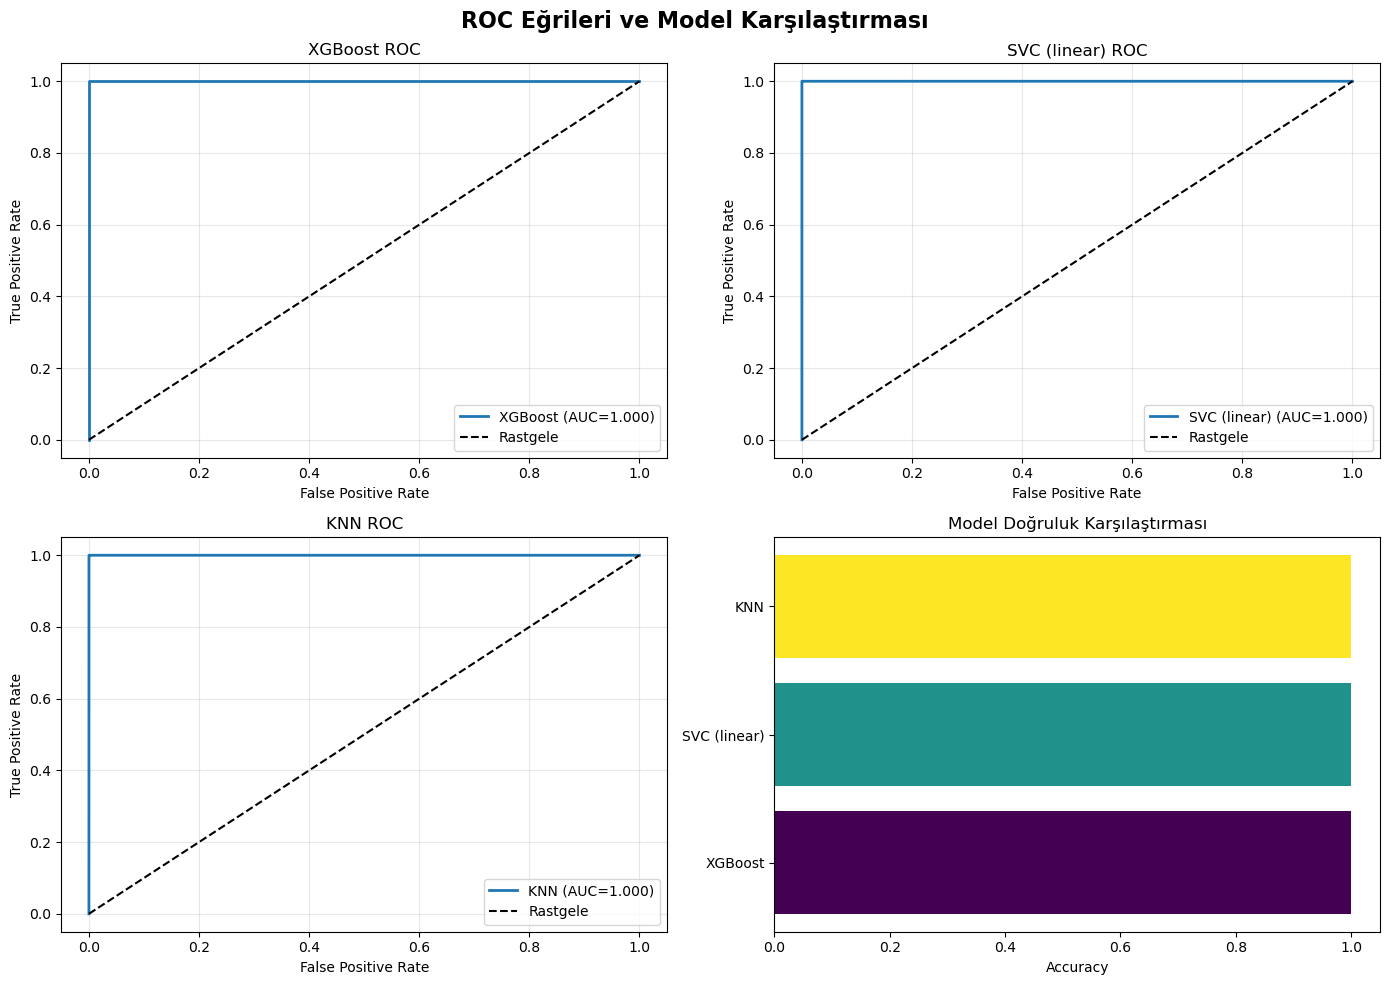

In [17]:
# =====================================================
# HÜCRE 7 – ROC EĞRİLERİ VE DOĞRULUK GÖRSELLERİ
# =====================================================
# Bu hücre:
# 1) XGBoost, SVC (linear) ve KNN için ROC eğrilerini çizer
# 2) Modellerin doğruluk skorlarını bar grafik olarak gösterir
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("ROC Eğrileri ve Model Karşılaştırması", fontsize=16, fontweight="bold")

# -------------------- ROC Eğrileri --------------------
for y_proba, label, ax in [
    (y_prob_xgb, "XGBoost",     axes[0, 0]),
    (y_prob_svc, "SVC (linear)", axes[0, 1]),
    (y_prob_knn, "KNN",         axes[1, 0]),
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--", label="Rastgele")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{label} ROC")
    ax.legend()
    ax.grid(alpha=0.3)

# -------------------- Doğruluk Bar Grafiği --------------------
ax = axes[1, 1]
models_acc = [
    ("XGBoost",     accuracy_score(y_test, y_pred_xgb)),
    ("SVC (linear)", accuracy_score(y_test, y_pred_svc)),
    ("KNN",         accuracy_score(y_test, y_pred_knn)),
]

ax.barh(
    [m[0] for m in models_acc],
    [m[1] for m in models_acc],
    color=plt.cm.viridis(np.linspace(0, 1, len(models_acc)))
)
ax.set_xlabel("Accuracy")
ax.set_title("Model Doğruluk Karşılaştırması")

plt.tight_layout()
plt.savefig("asil_roc_curves_comparison_fast_full.png", dpi=200, bbox_inches="tight")
print("\nasil_roc_curves_comparison_fast_full.png kaydedildi.")
plt.show()


asil_roc_curves_comparison_fast.png kaydedildi.


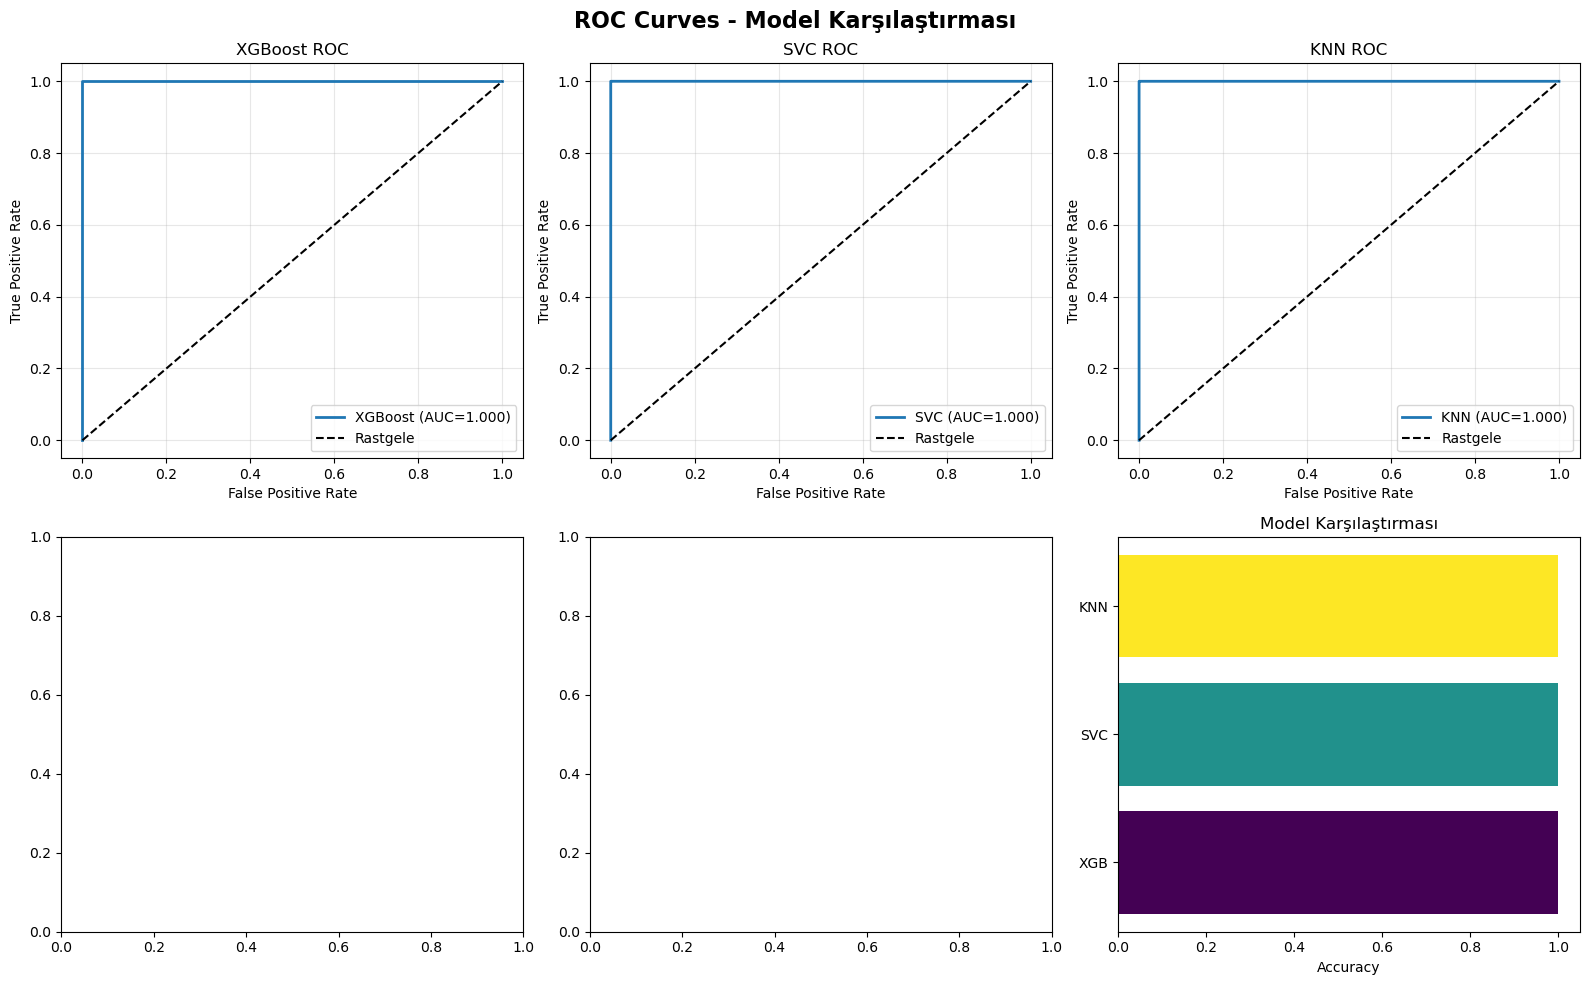

asil_class_distribution.png kaydedildi.


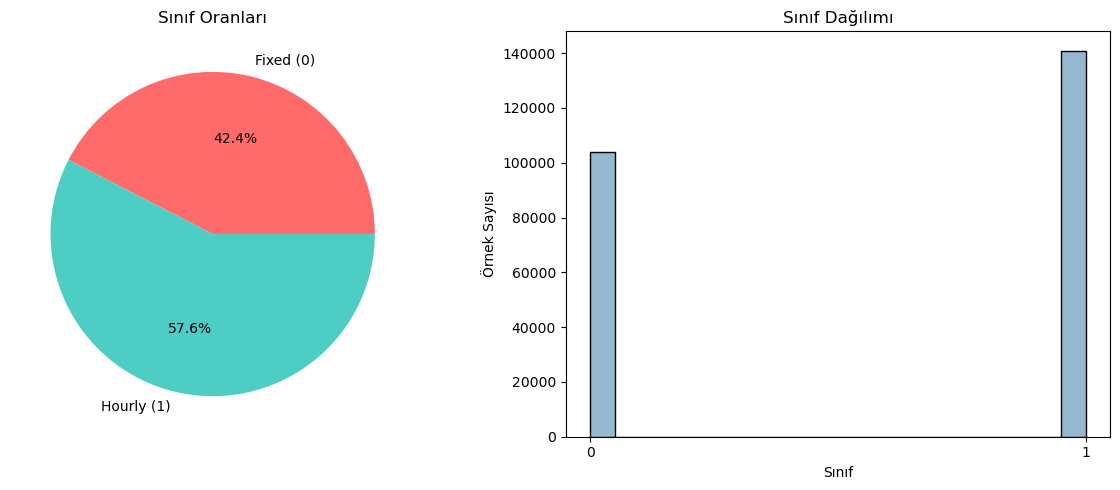


Asil için Sklearn notebook çalışması tamamlandı.


In [18]:
# =====================================================
# HÜCRE 8 – LSTM MODELİNİN EĞİTİLMESİ
# Bu hücre:
# 1) LSTM tabanlı bir model tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test setinde LSTM performansını hesaplar
# Not: Veri zamansal olmasa bile, ödev kapsamında LSTM kullanımı gösterilir.
# =====================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("ROC Curves - Model Karşılaştırması", fontsize=16, fontweight="bold")

for y_proba, label, ax in [
    (y_prob_xgb, "XGBoost", axes[0, 0]),
    (y_prob_svc, "SVC",    axes[0, 1]),
    (y_prob_knn, "KNN",    axes[0, 2])
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--", label="Rastgele")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{label} ROC")
    ax.legend()
    ax.grid(alpha=0.3)

# Doğruluk bar grafiği
ax = axes[1, 2]
models_acc = [
    ("XGB", accuracy_score(y_test, y_pred_xgb)),
    ("SVC", accuracy_score(y_test, y_pred_svc)),
    ("KNN", accuracy_score(y_test, y_pred_knn))
]
ax.barh(
    [m[0] for m in models_acc],
    [m[1] for m in models_acc],
    color=plt.cm.viridis(np.linspace(0, 1, len(models_acc)))
)
ax.set_xlabel("Accuracy")
ax.set_title("Model Karşılaştırması")

plt.tight_layout()
plt.savefig("asil_roc_curves_comparison_fast.png", dpi=200, bbox_inches="tight")
print("asil_roc_curves_comparison_fast.png kaydedildi.")
plt.show()

# Sınıf dağılımı görselleri
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sizes = pd.Series(y).value_counts().sort_index()

axes[0].pie(
    sizes,
    labels=["Fixed (0)", "Hourly (1)"],
    autopct="%1.1f%%",
    colors=["#FF6B6B", "#4ECDC4"]
)
axes[0].set_title("Sınıf Oranları")

axes[1].hist(y, bins=20, color="#95B8D1", edgecolor="black")
axes[1].set_title("Sınıf Dağılımı")
axes[1].set_xticks([0, 1])
axes[1].set_xlabel("Sınıf")
axes[1].set_ylabel("Örnek Sayısı")

plt.tight_layout()
plt.savefig("asil_class_distribution.png", dpi=200, bbox_inches="tight")
print("asil_class_distribution.png kaydedildi.")
plt.show()

print("\nAsil için Sklearn notebook çalışması tamamlandı.")


In [20]:
# =====================================================
# HÜCRE 9 – SINIF BAZLI METRİKLERİN HESAPLANMASI
# Bu hücre:
# 1) Her model için sınıf bazlı Precision, Recall, F1-Score hesaplar
# 2) Sonuçları CSV dosyasına kaydeder
# =====================================================

class_results = []

for y_pred, name in [
    (y_pred_xgb, "XGBoost"),
    (y_pred_svc, "SVC (linear)"),
    (y_pred_knn, "KNN"),
    # MLP ve LSTM ŞU AN YOK, O YÜZDEN BURAYA EKLEMİYORUZ
]:
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    for i in [0, 1]:
        class_results.append({
            "Model":    name,
            "Sinif":    f"{i} ({'Fixed' if i == 0 else 'Hourly'})",
            "Precision": round(prec[i], 4),
            "Recall":    round(rec[i], 4),
            "F1-Score":  round(f1[i], 4)
        })

class_df = pd.DataFrame(class_results)
print(class_df.to_string(index=False))

class_df.to_csv("asil_class_wise_metrics_fast_full.csv", index=False)
print("\nasil_class_wise_metrics_fast_full.csv dosyası kaydedildi.")


       Model      Sinif  Precision  Recall  F1-Score
     XGBoost  0 (Fixed)     1.0000  1.0000    1.0000
     XGBoost 1 (Hourly)     1.0000  1.0000    1.0000
SVC (linear)  0 (Fixed)     1.0000  1.0000    1.0000
SVC (linear) 1 (Hourly)     1.0000  1.0000    1.0000
         KNN  0 (Fixed)     1.0000  0.9997    0.9998
         KNN 1 (Hourly)     0.9998  1.0000    0.9999

asil_class_wise_metrics_fast_full.csv dosyası kaydedildi.


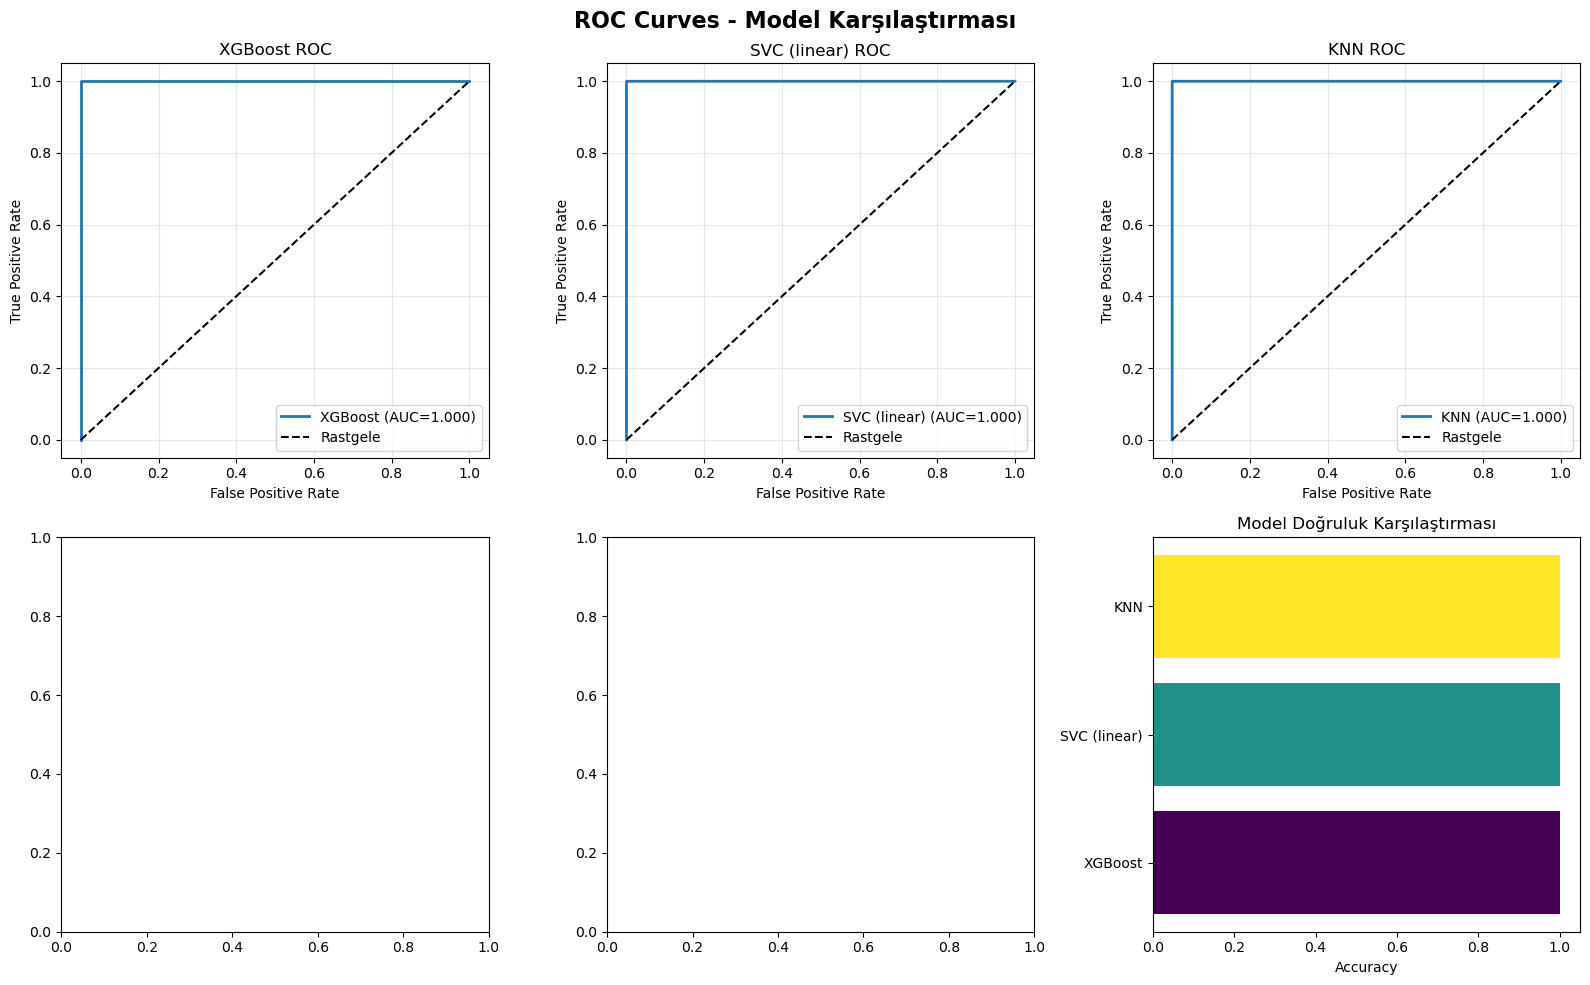

In [22]:
# =====================================================
# HÜCRE 10 – ROC EĞRİLERİ VE SINIF DAĞILIMI GÖRSELLERİ
# Bu hücre:
# 1) Tüm modeller için ROC eğrilerini tek figürde gösterir
# 2) Modellerin doğruluk skorlarını bar grafik olarak gösterir
# 3) Sınıf dağılımını pie ve histogram ile görselleştirir
# =====================================================

# ROC eğrileri ve model karşılaştırması
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("ROC Curves - Model Karşılaştırması", fontsize=16, fontweight="bold")

# Sadece tanımlı olan Sklearn modelleri: XGBoost, SVC (linear), KNN
for y_proba, label, ax in [
    (y_prob_xgb, "XGBoost",      axes[0, 0]),
    (y_prob_svc, "SVC (linear)", axes[0, 1]),
    (y_prob_knn, "KNN",          axes[0, 2]),
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--", label="Rastgele")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{label} ROC")
    ax.legend()
    ax.grid(alpha=0.3)

# Doğruluk bar grafiği
ax = axes[1, 2]
models_acc = [
    ("XGBoost",      accuracy_score(y_test, y_pred_xgb)),
    ("SVC (linear)", accuracy_score(y_test, y_pred_svc)),
    ("KNN",          accuracy_score(y_test, y_pred_knn)),
]
ax.barh(
    [m[0] for m in models_acc],
    [m[1] for m in models_acc],
    color=plt.cm.viridis(np.linspace(0, 1, len(models_acc)))
)
ax.set_xlabel("Accuracy")
ax.set_title("Model Doğruluk Karşılaştırması")

plt.tight_layout()
plt.savefig("asil_roc_curves_comparison_fast_full.png", dpi=200, bbox_inches="tight")
plt.show()
